
::: {.callout-tip}
### A Neutral Strategy, but Attacking Throw-Ins Show Promise

- This blog explores whether football (soccer) players should launch long balls into touch in the final third, conceding possession for a throw-in but gaining territorial advantage.
- On average, this strategy is neutral. Any advantage of being more likely to take the next shot as you're closer to the opposition goal is offset by the risk of facing counter-attacks with higher quality shot opportunities compared to what your team would have generated.
- On the other hand, if your team wins an attacking throw in the final third, it results in a positive expected goals (xG) difference (+0.014 per throw-in).

:::

### Should Players Launch a Long Ball into Touch, Conceding a Throw-in?
Inspired by rugby tactics, I investigated whether football players should employ a strategy of launching long balls into touch. This approach concedes possession via an opponent's throw-in but positions the ball closer to the opposition's goal. For this analysis, I utilized the Hudl StatsBomb [open-data](https://github.com/statsbomb/open-data) set from the 2015/16 season, covering the men's "Big-5" leagues (the top divisions in England, Italy, France, Spain, and Germany).

In [1]:
#| include: false
import pandas as pd
import numpy as np
from mplsoccer import Pitch, FontManager
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
import matplotlib.patheffects as path_effects
import os
import glob

In [2]:
#| include: false
# TODO change to clean data directory
save_dir = os.path.join('data_clean')
assert os.path.exists(save_dir)

In [3]:
#| include: false
files = glob.glob(os.path.join(save_dir, '*.parquet'))
df = pd.concat([pd.read_parquet(file) for file in files])
# how many throw-ins do not have a shot after them
print(len(df), df['x_shot'].isnull().sum(), df['x_shot'].isnull().mean())
# remove the throw-ins without a subsequent shot
df = df[df['x_shot'].notnull()].copy()
print(len(df))

84783 6061 0.07148838800231179
78722


In [4]:
#| include: false
df['time_diff'] = df['shot_time'] - df['throw_time']
df['diff_team'] = df['team_name_throw'] != df['team_name_shot']
df['same_team'] = df['team_name_throw'] == df['team_name_shot']
df['xg_shot'] = df['shot_statsbomb_xg_shot']
df.loc[df['diff_team'], 'xg_shot'] = - df.loc[df['diff_team'], 'xg_shot']

In [5]:
#| include: false
pitch = Pitch(line_zorder=2, pad_left=3, pad_right=3, pad_top=1, pad_bottom=13, goal_type='box', line_color='#e5e5e5')
path_eff = [path_effects.Stroke(linewidth=1.5, foreground='black'), path_effects.Normal()]
path_eff2 = [path_effects.Stroke(linewidth=0.5, foreground='black'), path_effects.Normal()]
fm_roboto = FontManager('https://raw.githubusercontent.com/googlefonts/roboto/main/src/hinted/Roboto-Regular.ttf')
fm_roboto_bold = FontManager('https://raw.githubusercontent.com/google/fonts/main/apache/robotoslab/RobotoSlab[wght].ttf')
fm_roboto_thin = FontManager('https://raw.githubusercontent.com/googlefonts/roboto/main/src/hinted/Roboto-Thin.ttf')
custom_cmap = LinearSegmentedColormap.from_list('greens', ['#edfff2', '#0d773d'], N=100)

### The Strategy is Neutral

Launching a long ball into touch is, on average, a neutral strategy.

1. Launching the ball into the final third touch means your team is more likely to take the next shot than your opponent.

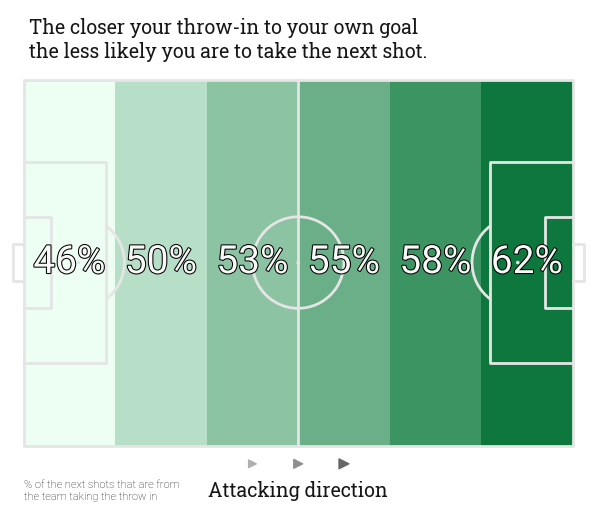

In [6]:
#| echo: false
fig, ax = pitch.grid(figheight=5, grid_height=0.86, grid_width=0.95, endnote_height=0,
                     title_height=0.12, title_space=0.01, axis=False)
bs = pitch.bin_statistic(df['x_throw'], df['y_throw'], values=df['same_team'], statistic='mean', bins=(6, 1))
hm = pitch.heatmap(bs, ax=ax['pitch'], cmap=custom_cmap)
txt = pitch.label_heatmap(bs, str_format='{:.0%}', color='#f8f8f8',
                          exclude_nan=True, fontsize=28,
                          fontproperties=fm_roboto.prop,
                          path_effects=path_eff, ax=ax['pitch'])
arrows = pitch.scatter([50, 60, 70], [84, 84, 84], marker='>', s=[30, 40, 50],
                       c=['#afafaf', '#8f8f8f', '#676767'], ax=ax['pitch'])
arrows_txt = pitch.text(60, 90, 'Attacking direction', fontproperties=fm_roboto_bold.prop,
                        ax=ax['pitch'], va='center', ha='center', fontsize=14, color='#161616')
title_txt = ax['title'].text(0.01, 0.5,
                             'The closer your throw-in to your own goal\nthe less likely you are to take the next shot.',
                             fontsize=14, ha='left', va='center',
                             color='#161616', fontproperties=fm_roboto_bold.prop)
desciption = pitch.text(0, 90,
                        '% of the next shots that are from\nthe team taking the throw in',
                        fontproperties=fm_roboto_thin.prop,
                        ax=ax['pitch'], va='center', ha='left', fontsize=8, color='#161616')

2. However, if your opponent retains possession from their resulting throw-in, they tend to create higher quality shot opportunities compared to what your team would have generated. 

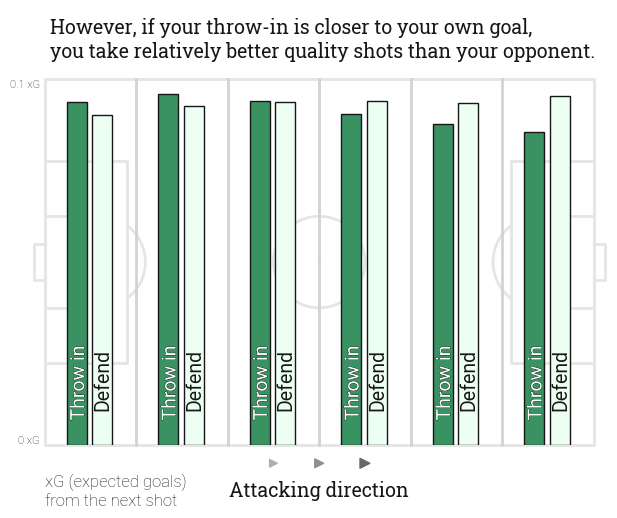

In [7]:
#| echo: false
df_attack = df[df['same_team']].copy()
df_defend = df[df['diff_team']].copy()
assert (len(df_attack) + len(df_defend)) == len(df)

bs_attack = pitch.bin_statistic(df_attack['x_throw'], df_attack['y_throw'],
                                values=df_attack['shot_statsbomb_xg_shot'],
                                statistic='mean', bins=(6, 1))
bs_defend = pitch.bin_statistic(df_defend['x_throw'], df_defend['y_throw'],
                                values=df_defend['shot_statsbomb_xg_shot'],
                                statistic='mean', bins=(6, 1))

fig, ax = pitch.grid(figheight=5, grid_height=0.86, grid_width=0.95, endnote_height=0,
                     title_height=0.12, title_space=0.01, axis=False)
for i, x in enumerate(bs_defend['cx'].ravel()):
    inset_ax = pitch.inset_axes(x, 40, width=20, height=80, ax=ax['pitch'])
    inset_ax.bar(0.52, bs_defend['statistic'][0, i], width=0.22, alpha=1, fc='#edfff2', ec='#161616', align='edge')
    inset_ax.bar(0.24, bs_attack['statistic'][0, i], width=0.22, alpha=1, fc='#3a9262', ec='#161616', align='edge')
    inset_ax.set_ylim(0, 0.1)
    inset_ax.axis('off')
    inset_ax.text(0.37, 0.017, 'Throw in', fontproperties=fm_roboto.prop, fontsize=14,
                  path_effects=path_eff2, color='white', rotation=90, va='center', ha='center')
    inset_ax.text(0.64, 0.018, 'Defend', fontproperties=fm_roboto.prop, fontsize=14,
                  color='#161616', rotation=90, va='center', ha='center')

deviders = ax['pitch'].plot([20, 20, np.nan, 40, 40, np.nan, 60, 60, np.nan, 80, 80, np.nan, 100, 100],
                            [0, 80, np.nan, 0, 80, np.nan, 0, 80, np.nan, 0, 80, np.nan, 0, 80],
                            color='#d3d3d3', lw=2, ls='-')
    
arrows = pitch.scatter([50, 60, 70], [84, 84, 84], marker='>', s=[30, 40, 50],
                       c=['#afafaf', '#8f8f8f', '#676767'], ax=ax['pitch'])
arrows_txt = pitch.text(60, 90, 'Attacking direction', fontproperties=fm_roboto_bold.prop,
                        ax=ax['pitch'], va='center', ha='center', fontsize=14, color='#161616')
title_txt = ax['title'].text(0.01, 0.5,
                             'However, if your throw-in is closer to your own goal,\nyou take relatively better quality shots than your opponent.',
                             fontsize=14, ha='left', va='center',
                             color='#161616', fontproperties=fm_roboto_bold.prop)
desciption = pitch.text(0, 90,
                        'xG (expected goals)\nfrom the next shot',
                        fontproperties=fm_roboto_thin.prop,
                        ax=ax['pitch'], va='center', ha='left', fontsize=12, color='#161616')
xg_bottom = pitch.text(-1, 80, '0 xG', fontproperties=fm_roboto_thin.prop,
                       ax=ax['pitch'], va='bottom', ha='right', fontsize=8, color='#161616')
xg_bottom = pitch.text(-1, 0, '0.1 xG', fontproperties=fm_roboto_thin.prop,
                       ax=ax['pitch'], va='top', ha='right', fontsize=8, color='#161616')

3. The higher shot quality of your opponent effectively negates any territorial gain from launching the ball. On average, this results in a neutral Expected Goals (xG) difference (approximately zero) from launching the ball into touch. Interestingly, an attacking throw-in in the final third does result in a positive xG difference (0.014 per throw-in).

In this analysis, I build on goal difference, and define xG difference as the sum of xG from the team taking the throw-in minus the sum of xG from the team defending the throw-in. A negative xG difference would suggest it's advantageous to kick the ball into touch and defend the throw-in, as the team taking the throw-in would, on average, concede more goals than they score.

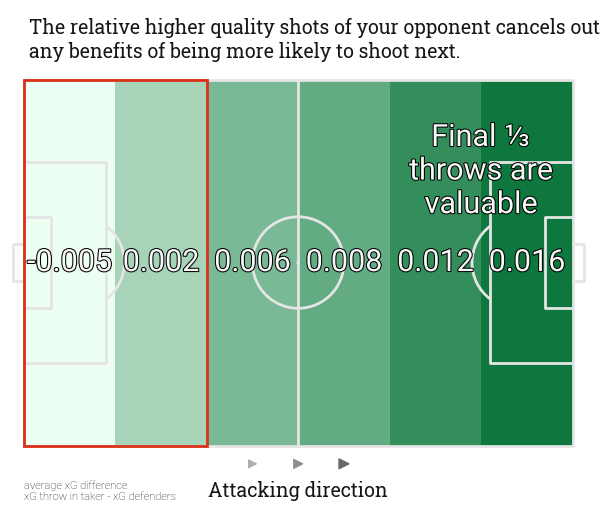

In [8]:
#| echo: false
fig, ax = pitch.grid(figheight=5, grid_height=0.86, grid_width=0.95, endnote_height=0,
                     title_height=0.12, title_space=0.01, axis=False)
bs_xg_diff = pitch.bin_statistic(df['x_throw'], df['y_throw'],
                                 values=df['xg_shot'],
                                 statistic='mean', bins=(6, 1))
hm = pitch.heatmap(bs_xg_diff, ax=ax['pitch'], cmap=custom_cmap)
txt = pitch.label_heatmap(bs_xg_diff, str_format='{0:.3f}', color='#f8f8f8',
                          exclude_nan=True, fontsize=22,
                          fontproperties=fm_roboto.prop,
                          path_effects=path_eff, ax=ax['pitch'])
arrows = pitch.scatter([50, 60, 70], [84, 84, 84], marker='>', s=[30, 40, 50],
                       c=['#afafaf', '#8f8f8f', '#676767'], ax=ax['pitch'])
arrows_txt = pitch.text(60, 90, 'Attacking direction', fontproperties=fm_roboto_bold.prop,
                        ax=ax['pitch'], va='center', ha='center', fontsize=14, color='#161616')
title = ('The relative higher quality shots of your opponent cancels out\n'
         'any benefits of being more likely to shoot next.')
title_txt = ax['title'].text(0.01, 0.5,
                             title,
                             fontsize=14, ha='left', va='center',
                             color='#161616', fontproperties=fm_roboto_bold.prop)
pitch.text(100, 20, 'Final ⅓\nthrows are\nvaluable', color='#f8f8f8', fontsize=22, va='center', ha='center',
           path_effects=path_eff, fontproperties=fm_roboto.prop, ax=ax['pitch'])
desciption = pitch.text(0, 90,
                        'average xG difference\nxG throw in taker - xG defenders',
                        fontproperties=fm_roboto_thin.prop,
                        ax=ax['pitch'], va='center', ha='left', fontsize=8, color='#161616')

rect = patches.Rectangle((0, 0), 40, 80, linewidth=2, edgecolor='#da3119',
                         facecolor='None', zorder=3)
ax['pitch'].add_patch(rect)

For this analysis, I matched data from approximately 79,000 throw-ins to the next shot in the game period (excluding about 6,000 throw-ins without a subsequent shot). It's important to note that the data is ten years old, potentially missing recent advances in [advances in set piece tactics](https://statsbomb.com/articles/soccer/i-think-we-broke-denmark/) and pressing strategies employed by teams.

### Summary: A Neutral Strategy, but Attacking Throw-Ins Show Promise

While launching the ball into touch doesn't appear to be a viable strategy on average, there may be exploitable positional lineups, pressing systems, or specific circumstances that could make this strategy effective and counter the risk of conceding higher-quality shots. However, even a decade ago, attacking throw-ins in the final third showed potential for gains. As Ted Knutson notes in the [Transfer Flow podcast](https://www.youtube.com/watch?v=SVOXXS41uSs), throw-ins offer three distinct advantages over open play passes:

1. you cannot be offside.
2. you can plan mismatches and overloads.
3. the player taking the throw in can see all the players on the pitch.